<a href="https://colab.research.google.com/github/TillVollmer5/mass_spectroscopy/blob/main/Calibration_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibration calculation
This skript aims to allow the calculation and generation of a linear regression to allow the quantivication of phthalates in the environement.

Input: The the peak list files (classic structure, header = 6, by thermofisher) are uploaded to the directory titeled *calibration_input*, it is of key importance that the title of the files follows the format: Cal_"conc.nr"_"series.nr"_"identification.nr"_pl.csv Any changes to filename, path or other changes that might impact the file significantly need to be comented and marked extensively.

The following code serves to import the librarys and mount the google drive. Additionally, the x-axis values, meaning the concentration values are imported and converted from a list containing only strings to a list containing a floats. The string section is used for the import of the files (input files do not contain ".") where the float version is used for formating, plotting and calculational actions. The x-axis values should be writen for each series and changed accordingly. The filname should be set as:
***x_values.csv***

In [6]:
#Import of all librarys required for the following code sections
import numpy as np
from google.colab import drive
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import re

drive.mount('/content/drive', force_remount = True)

#Read the list of strings from a CSV file to get the x_values
strings = []
with open('/content/drive/My Drive/calibration_input/x_values_2.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        strings.extend(row)

#Separating values and removing Nan if present
values = []
for string in strings:
    split_values = string.split(';')
    non_empty_values = [value for value in split_values if value.strip()]
    values.extend(non_empty_values)
values.reverse()

#Add decimals and save floats
values_float = []
for value in values:
    if value.startswith('0'):
        value_float = '0.' + value[1:]
    else:
        value_float = value
    values_float.append(float(value_float))

#Display all the lists
print(strings)
print(values)
print(values_float)

Mounted at /content/drive
['05', '025', '0125', '00625', '003125', '0015625']
['0015625', '003125', '00625', '0125', '025', '05']
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]


This loop aims at importing the various files from the google drive, looping through each row (each row is one analyte or the internal standard) and saving them in a new file. This code requires the output variables (values) from the previous code section as well as the peak list files. The output specific in files for the row and concentration (repetition analysis number is removed) and saved in the output folder.

In [7]:
#Loop over all concentrations defined in the x-axis
for n in values:
    files = glob.glob(f'/content/drive/My Drive/calibration_input/Cal_{n}ug*.csv')

    #Control loop checking for file prescence
    if not files:
        print(f'Files matching pattern "Cal_{n}ug*.csv" were not found.')
        break

    else:
        #Import all the files according to the previous condition
        df = pd.read_csv(files[0], header=4)
        num_rows = len(df)
        #Loop over each row (information of one compound) and save a separate data frame
        for i in range(num_rows):
            row_dfs = []
            for file in files:
                df = pd.read_csv(file, header=4, na_values='')

                #Extract the i'th row of the CSV file and append it to the row data frame list
                row = df.iloc[i, :].dropna().astype(str)
                row_dfs.append(row)

            #Concatenate the row data frames along the columns axis and convert to a data frame
            combined_df = pd.concat(row_dfs, axis=1).T
            combined_df.to_csv(f'/content/drive/My Drive/calibration_output/Cal_{n}ug_ml_row{i+1}.csv', index=False, header=False, sep=';')

            #Convert all values to strings before joining and print the row in the desired format
            formatted_row = '\t'.join(map(str, combined_df.values[0]))
            print(file)


/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_0015625ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/calibration_input/Cal_003125ug_ml_2_1_pl.csv
/content/drive/My Drive/cal

The following lines use the previously created row file and take the average and the standard deviation *(or the error)* and add them to two new files respectively. This code section requires the extracted row files from the previous section, the following output will have the tag "_mean"  for the files containing the averaged data and "_std" for the files containing the standard deviation.

Currently there is no error calculation in place that goes further than this, which needs to be done in the future, as this will not suffice as a long term option.

In [8]:
files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*.csv')
#Loop over each files that fullfills the previously stated condition
for file in files:
    df = pd.read_csv(file, header=None, sep=';')
    #Calculate the mean and standard deviation
    df_mean = df.mean(axis=0)
    df_mean = df_mean.transpose().to_frame().T
    df_std = df.std(axis=0)
    df_std = df_std.transpose().to_frame().T

    #Display the calculated values
    #print(df_mean)
    #print(df_std)

    #Save both the files as .csv
    file_name = os.path.basename(file)

    mean_file_path = '/content/drive/My Drive/calibration_output/' + file_name[:-4] + '_mean.csv'
    df_mean.to_csv(mean_file_path, index=False)

    std_file_path = '/content/drive/My Drive/calibration_output/' + file_name[:-4] + '_std.csv'
    df_std.to_csv(std_file_path, index=False)

    print(mean_file_path)
    print(std_file_path)

/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row1_mean.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row1_std.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row2_mean.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row2_std.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row3_mean.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row3_std.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row4_mean.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row4_std.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row5_mean.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row5_std.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row6_mean.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row6_std.csv
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row7_mean.csv
/content/drive/My Drive/calibration_output/C

Two files contain the internal standard signals are used to take the ratio of the various signals and save the values in a new file. The file needs to be specified so that the internal standard signal correlates to the divisor name, so that this leads to the correct ratio. The first one calculates the ratio of the mean and the bottom one being used for the ratio of the standard deviation, although that might be insuficient and should be substituted by an appropriate error calculation (possibly gaussian errorpropagation).

In [9]:
directory = '/content/drive/My Drive/calibration_output'

for n in (values):
    divisor_file = f'/content/drive/My Drive/calibration_output/Cal_{n}ug_ml_row3_mean.csv'

    divisor_row = pd.read_csv(divisor_file, sep=',', header=None)
    #print(divisor_row)
    csv_files = glob.glob(os.path.join(directory, f'Cal_{n}ug_ml_*_mean.csv'))

    # Process each CSV file
    for csv_file in csv_files:
        if csv_file == divisor_file:
            continue  # Skip the divisor file itself

        data_df = pd.read_csv(csv_file, sep=',', header=None)
        #print(data_df)
        data_df = data_df.apply(pd.to_numeric, errors='coerce')  # Convert values to numeric

        # Perform division on the data
        divided_data_df = data_df.div(divisor_row, axis='columns')
        #print(divided_data_df)
        #Create a new file name with the "_ratio" tag
        new_file_name = os.path.splitext(csv_file)[0] + '_ratio.csv'

        divided_data_df.to_csv(new_file_name, sep='\t', header=False, index=False)
        print(new_file_name)
        control_import_df = pd.read_csv(new_file_name, sep='\t', header=0)

        if control_import_df.equals(divided_data_df):
            print(f"The files match: {new_file_name}")
        else:
            print(f"The files do not match: {new_file_name}")

        print(control_import_df)
        print(divided_data_df)
        print('****************************************************')



/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row1_mean_ratio.csv
The files do not match: /content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row1_mean_ratio.csv
   Unnamed: 0       1.0     1.0.1     1.0.2  1.0.3    1.0.4  1.0.5
0    0.706731  0.706847  0.711271  0.000859    1.0  0.00085    1.0
          0         1         2         3    4        5    6
0       NaN  1.000000  1.000000  1.000000  1.0  1.00000  1.0
1  0.706731  0.706847  0.711271  0.000859  1.0  0.00085  1.0
****************************************************
/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row2_mean_ratio.csv
The files do not match: /content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row2_mean_ratio.csv
   Unnamed: 0       1.0     1.0.1     1.0.2   1.0.3     1.0.4   1.0.5
0    0.840385  0.839923  0.844604  0.000852  0.3318  0.000892  0.3545
          0         1         2         3       4         5       6
0       NaN  1.000000  1.000000  1.000000  1.0000  1.0

The following script creates a plot of the chromatogram peak area ratio of the analytes and the internal standard and the corresponding concentration. For this reason the output files for the various rows (analyte) for the previous code sequence are nescessary, as well as the variable containing the list of the concentration values (from the first section of code of this notebook). One diagram is created for one row/analyte and saved in the export folder on the google drive as a pdf. The file only contains the various data points, not the linear function, which could be implemented knowing the data from a later code sequence in this notebook. Additionally, the designe of the plots was keept minimalistic and simple, which could be changed at a later date.

Output file:

***Cal_{n}_analyte_calibration_curve.pdf***

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]
[[0.0008593435519703], [0.0021099864284537], [0.0040122043646177], [0.0120716143206021], [0.0176235324195174], [0.0293162052572042]]


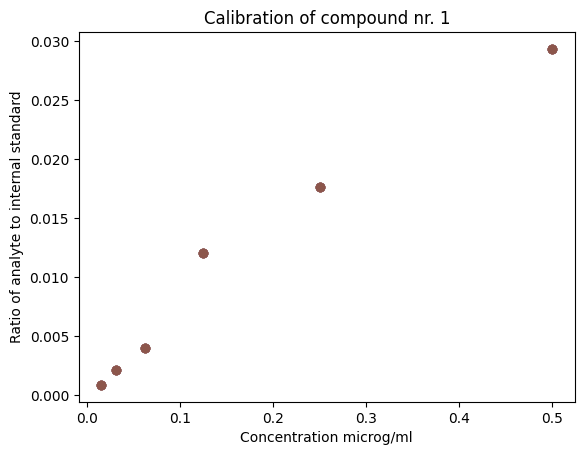

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]
[[0.0008522488356978], [0.0021382108428264], [0.0041552389087171], [0.0134456925402998], [0.019043232299181], [0.0352176486830538]]


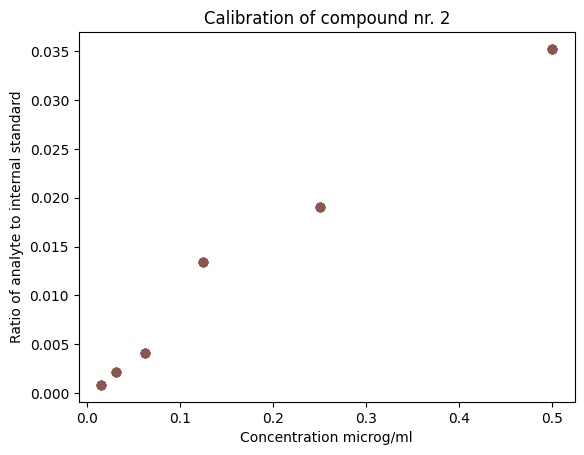

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]
[[0.0010316113830067], [0.002482894820397], [0.0048467666333494], [0.0171931009282967], [0.0261474096510074], [0.057614751903941]]


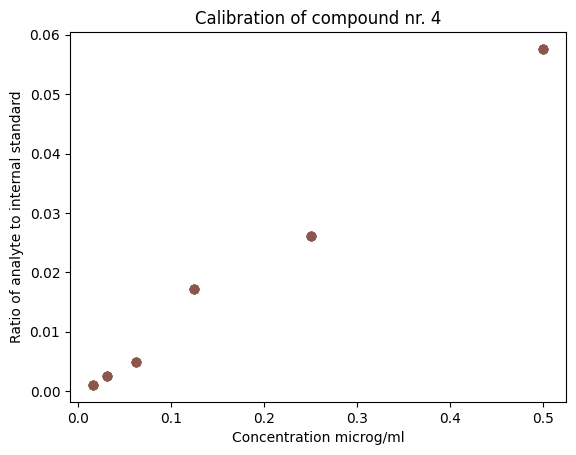

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]
[[0.0002021133944915], [0.0005129126556388], [0.0010116601704509], [0.0036592660809514], [0.0061910143617701], [0.0137480483493785]]


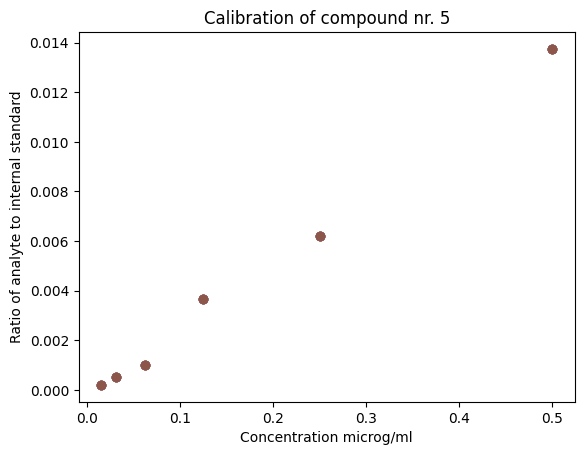

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]
[[0.0002898012586182], [0.0006993389771081], [0.0013811953054712], [0.0051727620511763], [0.0081347788645246], [0.0210147891403557]]


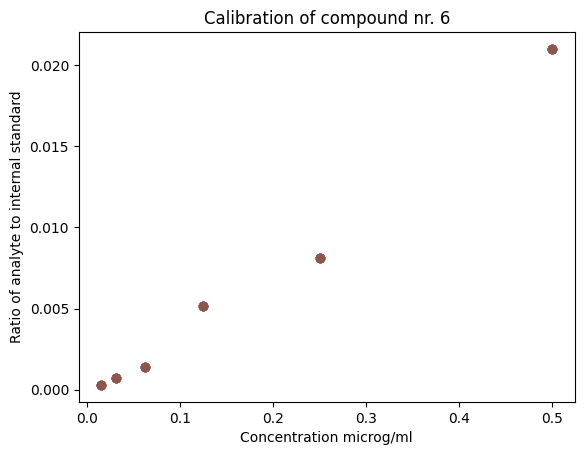

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5]
[[0.0001924068384018], [0.0004854216260961], [0.0009656359621239], [0.0035732689604762], [0.0058886210306035], [0.0140450953895147]]


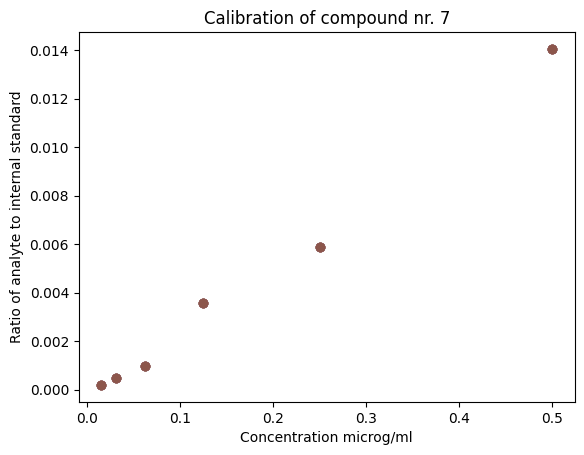

In [10]:
#Define range according to number of signals and rows in the peaklist
comp_1 = 1
comp_fin = 8

#Loop over all rows with the limits designated above
for n in range(comp_1, comp_fin):
    files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*ug_ml_row{n}*_ratio.csv')

    if n == 3: #The internal standard row is skipped
      continue

    y_values = []

    for file in files:
        y_data = pd.read_csv(file, header=None, sep='\t')
        #print(y_data.head())
        if not y_data.empty:
            if y_data.shape[1] >= 4:  #Check if the DataFrame has at least four columns
                y_values.append(y_data.iloc[1:, 3].tolist())
            else:
                print(f"DataFrame does not have the fourth column: {file}") #Control statement to check the format of the file
        else:
            print(f"Empty DataFrame: {file}") #Control statement to check the content of the file

    print(values_float)
    print(y_values)

    #Create empty plot
    fig, ax = plt.subplots()

    for y in y_values:
        ax.scatter(values_float, list((y_values))) #Add all the y-values into the plot

    #Formating of the plot
    ax.set_xlabel("Concentration microg/ml")
    ax.set_ylabel("Ratio of analyte to internal standard")
    ax.set_title(f"Calibration of compound nr. {n}")

    #Saving and presenting of the plot
    plt.savefig(f"/content/drive/My Drive/calibration_export/Cal_{n}_analyte_calibration_curve.pdf")
    plt.show()

The following code allows to fit a linear function to the datasets present for each compound. The files with the tag "_ratio" are required in adition to the concentration values for the x-axis (from the first code sequence of the notebook). The output of this script is saved in the export folder of the google drive and contains the intercept, the slope and the R2 value of a fitted function.

Output file:

***Cal_{n}_analyte_linreg.csv***

In [11]:
# Define range according to number of signals and rows in the peaklist
comp_1 = 1
comp_fin = 8

# Loop over all rows with the limits designated above
for n in range(comp_1, comp_fin):
    if n == 3:  # Skip the data of the internal standard
        continue

    files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*ug_ml_row{n}*_ratio.csv')
    print(files)
    x_values = []  # Independent variable

    # Add all x-data into one variable
    for file in files:
        x_data = pd.read_csv(file, header=None, sep='\t')
        # print(x_data.head())
        if not x_data.empty:
            if x_data.shape[1] >= 4:  # Check if the DataFrame has at least four columns
                x_values.append(x_data.iloc[1:, 3].tolist())
            else:
                print(f"DataFrame does not have the fourth column: {file}")  # Control statement to check the format of the file
        else:
            print(f"Empty DataFrame: {file}")  # Control statement to check the content of the file

    y_values = np.array(values_float).reshape(-1, 1)  # Access the first column by index and reshape to a 2D array

    # print(x_values)
    # print(y_values)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(x_values, y_values)

    # Predict using the model
    x_pred = model.predict(x_values)

    # Calculate the R^2 value
    r2 = r2_score(y_values, x_pred)

    # Get the learned coefficients
    intercept = model.intercept_
    slope = model.coef_

    # Save the data as a .csv file
    output_file = f"/content/drive/My Drive/calibration_export/Cal_{n}_analyte_linreg.csv"
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Intercept", "Slope", "R2 Value"])
        writer.writerow([intercept, slope, r2])

    # Display as control
    print("Output saved to:", output_file)
    print(intercept, slope, r2)


['/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row1_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_003125ug_ml_row1_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_00625ug_ml_row1_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0125ug_ml_row1_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_025ug_ml_row1_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_05ug_ml_row1_mean_ratio.csv']
Output saved to: /content/drive/My Drive/calibration_export/Cal_1_analyte_linreg.csv
[-0.01726225] [[16.48584551]] 0.9671633471151561
['/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row2_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_003125ug_ml_row2_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_00625ug_ml_row2_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0125ug_ml_row2_mean_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_025ug_m